In [241]:
import sys
import os
import time
import numpy as np
np.random.seed(42)

import json
import tensorflow as tf

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
#%matplotlib notebook
#%matplotlib inline
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore', module='numpy')
warnings.filterwarnings('ignore')

import importlib
git_dir = os.path.join(os.path.expanduser('~'), 'git', 'nh3-analysis')
src_dir = os.path.join(os.path.expanduser('~'), 'git', 'time-resolved-nr', 'src')
sys.path.append(src_dir)

from stable_baselines3 import PPO, SAC
from stable_baselines3.common.callbacks import CheckpointCallback


In [370]:
import rl_model
importlib.reload(rl_model)

initial_state_expt_file = os.path.join(git_dir, 'jan2023', 'dyn-fitting', '201282-expt.json')
final_state_expt_file = os.path.join(git_dir, 'jan2023', 'dyn-fitting', '201289-435s-expt.json')
data_file = os.path.join(git_dir, 'jan2023', 'data', 'r201289-time-resolved.json')

initial_state_expt_file = os.path.join(git_dir, 'jan2023', 'dyn-fitting', '201341-expt.json')
final_state_expt_file = os.path.join(git_dir, 'jan2023', 'dyn-fitting', '201349-expt.json')
data_file = os.path.join(git_dir, 'jan2023', 'data', 'r201348-time-resolved.json')


REVERSE = False
MIXING = False
MAX_TIME = 30

with open(data_file) as fd:
    m = json.load(fd)
    timestamps = np.asarray(m['times'][:MAX_TIME])
    _data = m['data'][:MAX_TIME]
    print("Number of times: %s" % len(_data))
print(timestamps)

# create an instance of our custom environment
env = rl_model.SLDEnv(initial_state_file=initial_state_expt_file,
                      final_state_file=final_state_expt_file,
                      data=_data[:MAX_TIME], reverse=REVERSE, allow_mixing=MIXING)

# use the Gymnasium 'check_env' function to check the environment
# - returns nothing if the environment is verified as ok
from gymnasium.utils.env_checker import check_env
check_env(env)

# initialize the environment
env.reset()
env.render()



Number of times: 30
[  0  30  60  90 120 150 180 210 240 270 300 330 360 390 420 450 480 510
 540 570 600 630 660 690 720 750 780 810 840 870]
0


<IPython.core.display.Javascript object>


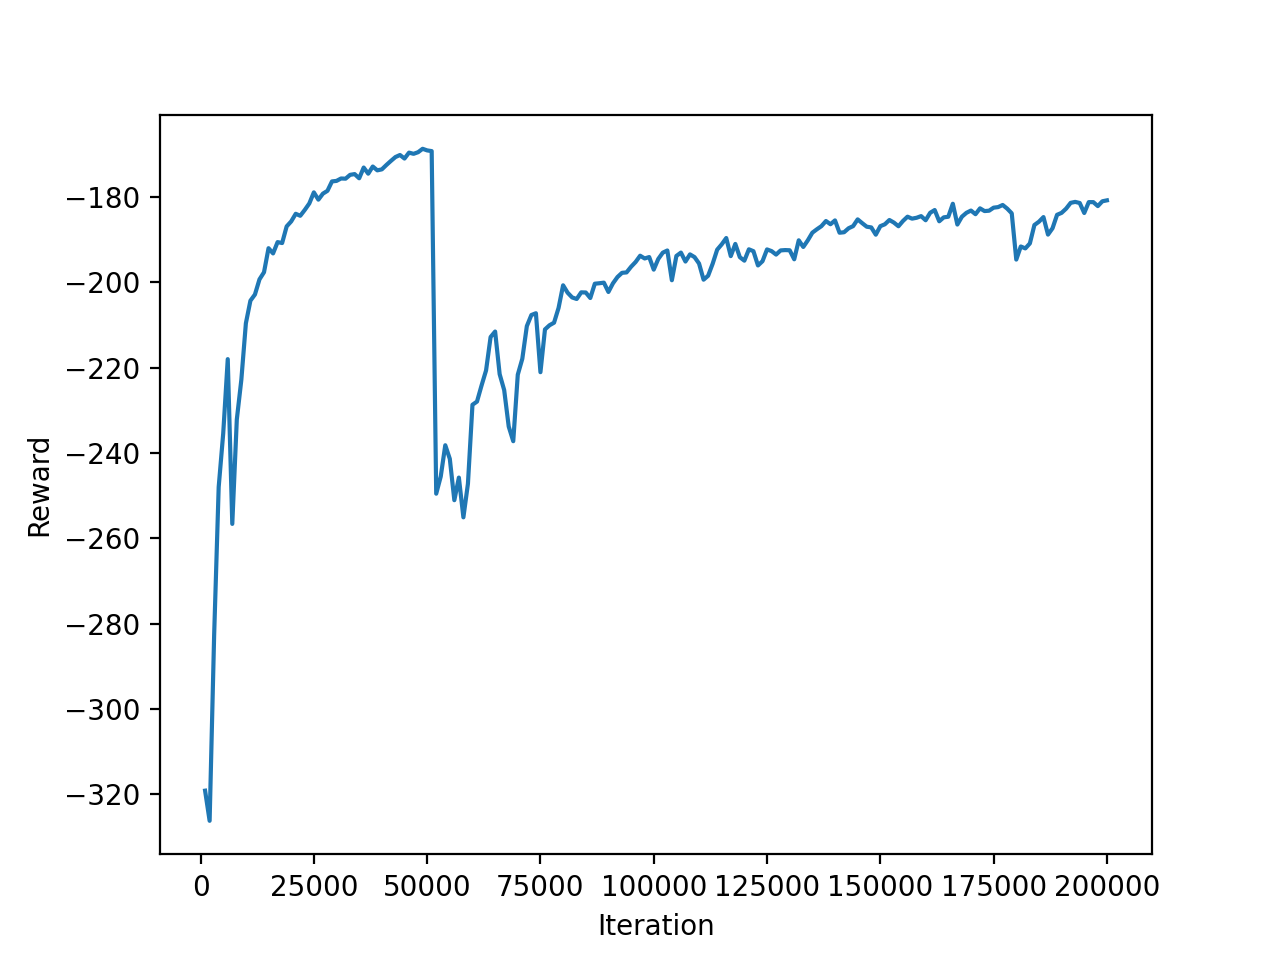

In [371]:
log_dir = "./logs-201289-fwd/"
log_dir = "./logs-201248-fwd/"


_dir_list = os.listdir(log_dir)

def evaluate(model):
    episode_reward = 0
    n_times = len(env.data)
    obs, info = env.reset()

    chi2 = 0
    time_chi2 = []
    
    for i in range(MAX_TIME):
        action, _ = model.predict(obs, deterministic=True)
        chi2 += env.chi2
        obs, reward, terminated, truncated, info = env.step(action)  
        episode_reward += reward
        time_chi2.append(reward)

    return episode_reward, time_chi2

itr_list = []
reward_list = []
time_chi2_list = []
models = []

for file in _dir_list:
    try:
        model = SAC.load(os.path.join(log_dir, file))
        reward, time_chi2 = evaluate(model)
        iteration = int(file.replace("rl_model_", "").replace("_steps.zip", ""))
        itr_list.append(iteration)
        reward_list.append(reward)
        time_chi2_list.append(time_chi2)
        models.append(model)
    except:
        print("skip: %s" % file)


time_chi2_list = np.asarray(time_chi2_list)
itr_list = np.asarray(itr_list)
reward_list = np.asarray(reward_list)
idx = itr_list.argsort()

fig = plt.figure(dpi=100)
plt.plot(itr_list[idx], reward_list[idx])
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.show()

(200, 30)
200000


<IPython.core.display.Javascript object>


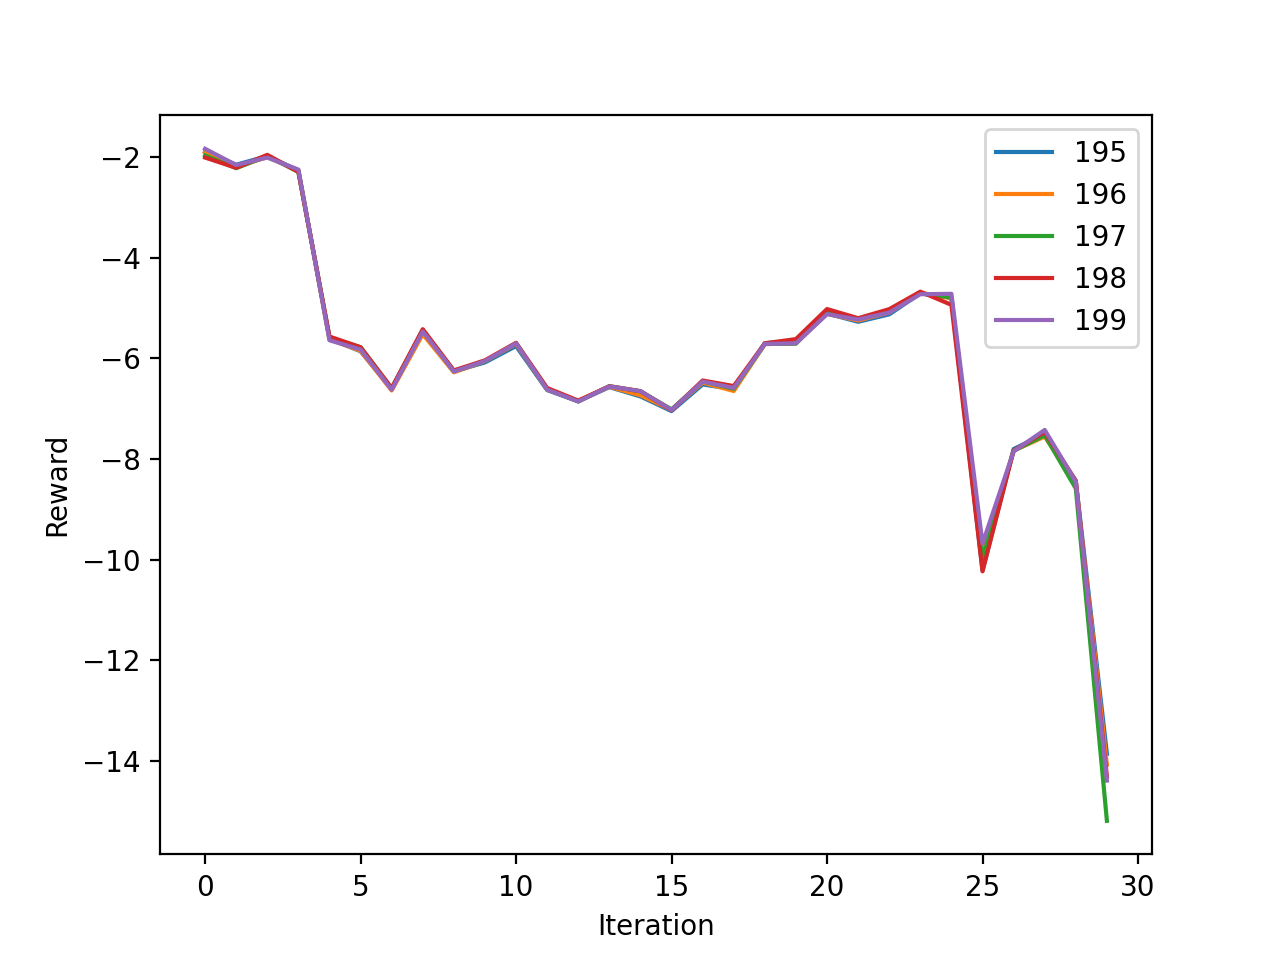

In [372]:
print(time_chi2_list.shape)
print(itr_list[idx][-1])

fig = plt.figure(dpi=100)

for i in range(len(time_chi2_list)-5, len(time_chi2_list)):   
    plt.plot(np.arange(time_chi2_list.shape[1]), time_chi2_list[idx][i], label=str(i))
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.legend()
plt.show()

In [373]:
# Evaluate the agent
#Nature catalyssiis 2 1055 2019

model = models[idx[-1]]
episode_reward = 0

n_times = len(env.data)
print("Number of times: %s" % n_times)

obs, info = env.reset()

times = []
actions = []
chi2 = []
for i in range(n_times):
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)
    times.append(timestamps[env.time_stamp])
    _time = timestamps[env.time_stamp]
    new_obs, reward, terminated, truncated, info = env.step(action)  
    chi2.append(env.chi2)
    episode_reward += reward
    print("Time %s %s: %g [%s] %g" % (_time, obs, reward, terminated, episode_reward))
    obs = new_obs


actions = np.asarray(actions)
chi2 = np.asarray(chi2)
times = np.asarray(times)
print(times)

Number of times: 30
Time 0 [0.]: -1.84152 [False] -1.84152
Time 30 [0.03448276]: -2.16419 [False] -4.00571
Time 60 [0.06896552]: -2.01583 [False] -6.02154
Time 90 [0.10344828]: -2.25387 [False] -8.27541
Time 120 [0.13793103]: -5.64396 [False] -13.9194
Time 150 [0.1724138]: -5.82629 [False] -19.7457
Time 180 [0.20689656]: -6.62624 [False] -26.3719
Time 210 [0.2413793]: -5.46946 [False] -31.8414
Time 240 [0.27586207]: -6.26403 [False] -38.1054
Time 270 [0.31034482]: -6.05577 [False] -44.1612
Time 300 [0.3448276]: -5.70635 [False] -49.8675
Time 330 [0.37931034]: -6.62278 [False] -56.4903
Time 360 [0.41379312]: -6.85865 [False] -63.3489
Time 390 [0.44827586]: -6.56046 [False] -69.9094
Time 420 [0.4827586]: -6.65417 [False] -76.5636
Time 450 [0.51724136]: -7.02731 [False] -83.5909
Time 480 [0.55172414]: -6.46367 [False] -90.0545
Time 510 [0.5862069]: -6.5899 [False] -96.6444
Time 540 [0.62068963]: -5.71554 [False] -102.36
Time 570 [0.6551724]: -5.70443 [False] -108.064
Time 600 [0.6896552]:

In [374]:
deltas = env.high_array - env.low_array

samples = []
mixing = []

for n in range(100):
    actions = []
    obs, info = env.reset()
    for i in range(len(env.data)):
        action, _ = model.predict(obs, deterministic=False)
        obs, reward, terminated, truncated, info = env.step(action)
        actions.append(action)
    
    actions = np.asarray(actions)
    values = env.low_array + (1+actions[:,:len(env.parameters)]) * deltas / 2.0
    samples.append(values)

    if MIXING:
        mixing.append((1+actions[:,-1]) / 2.0)


samples = np.asarray(samples).T
mixing = np.asarray(mixing).T
print(samples.shape)

errs = np.std(samples, axis=2)
print(errs.shape)

if MIXING:
    mixing_err = np.std(mixing, axis=1)
    print(mixing_err.shape)

(5, 30, 100)
(5, 30)


<IPython.core.display.Javascript object>


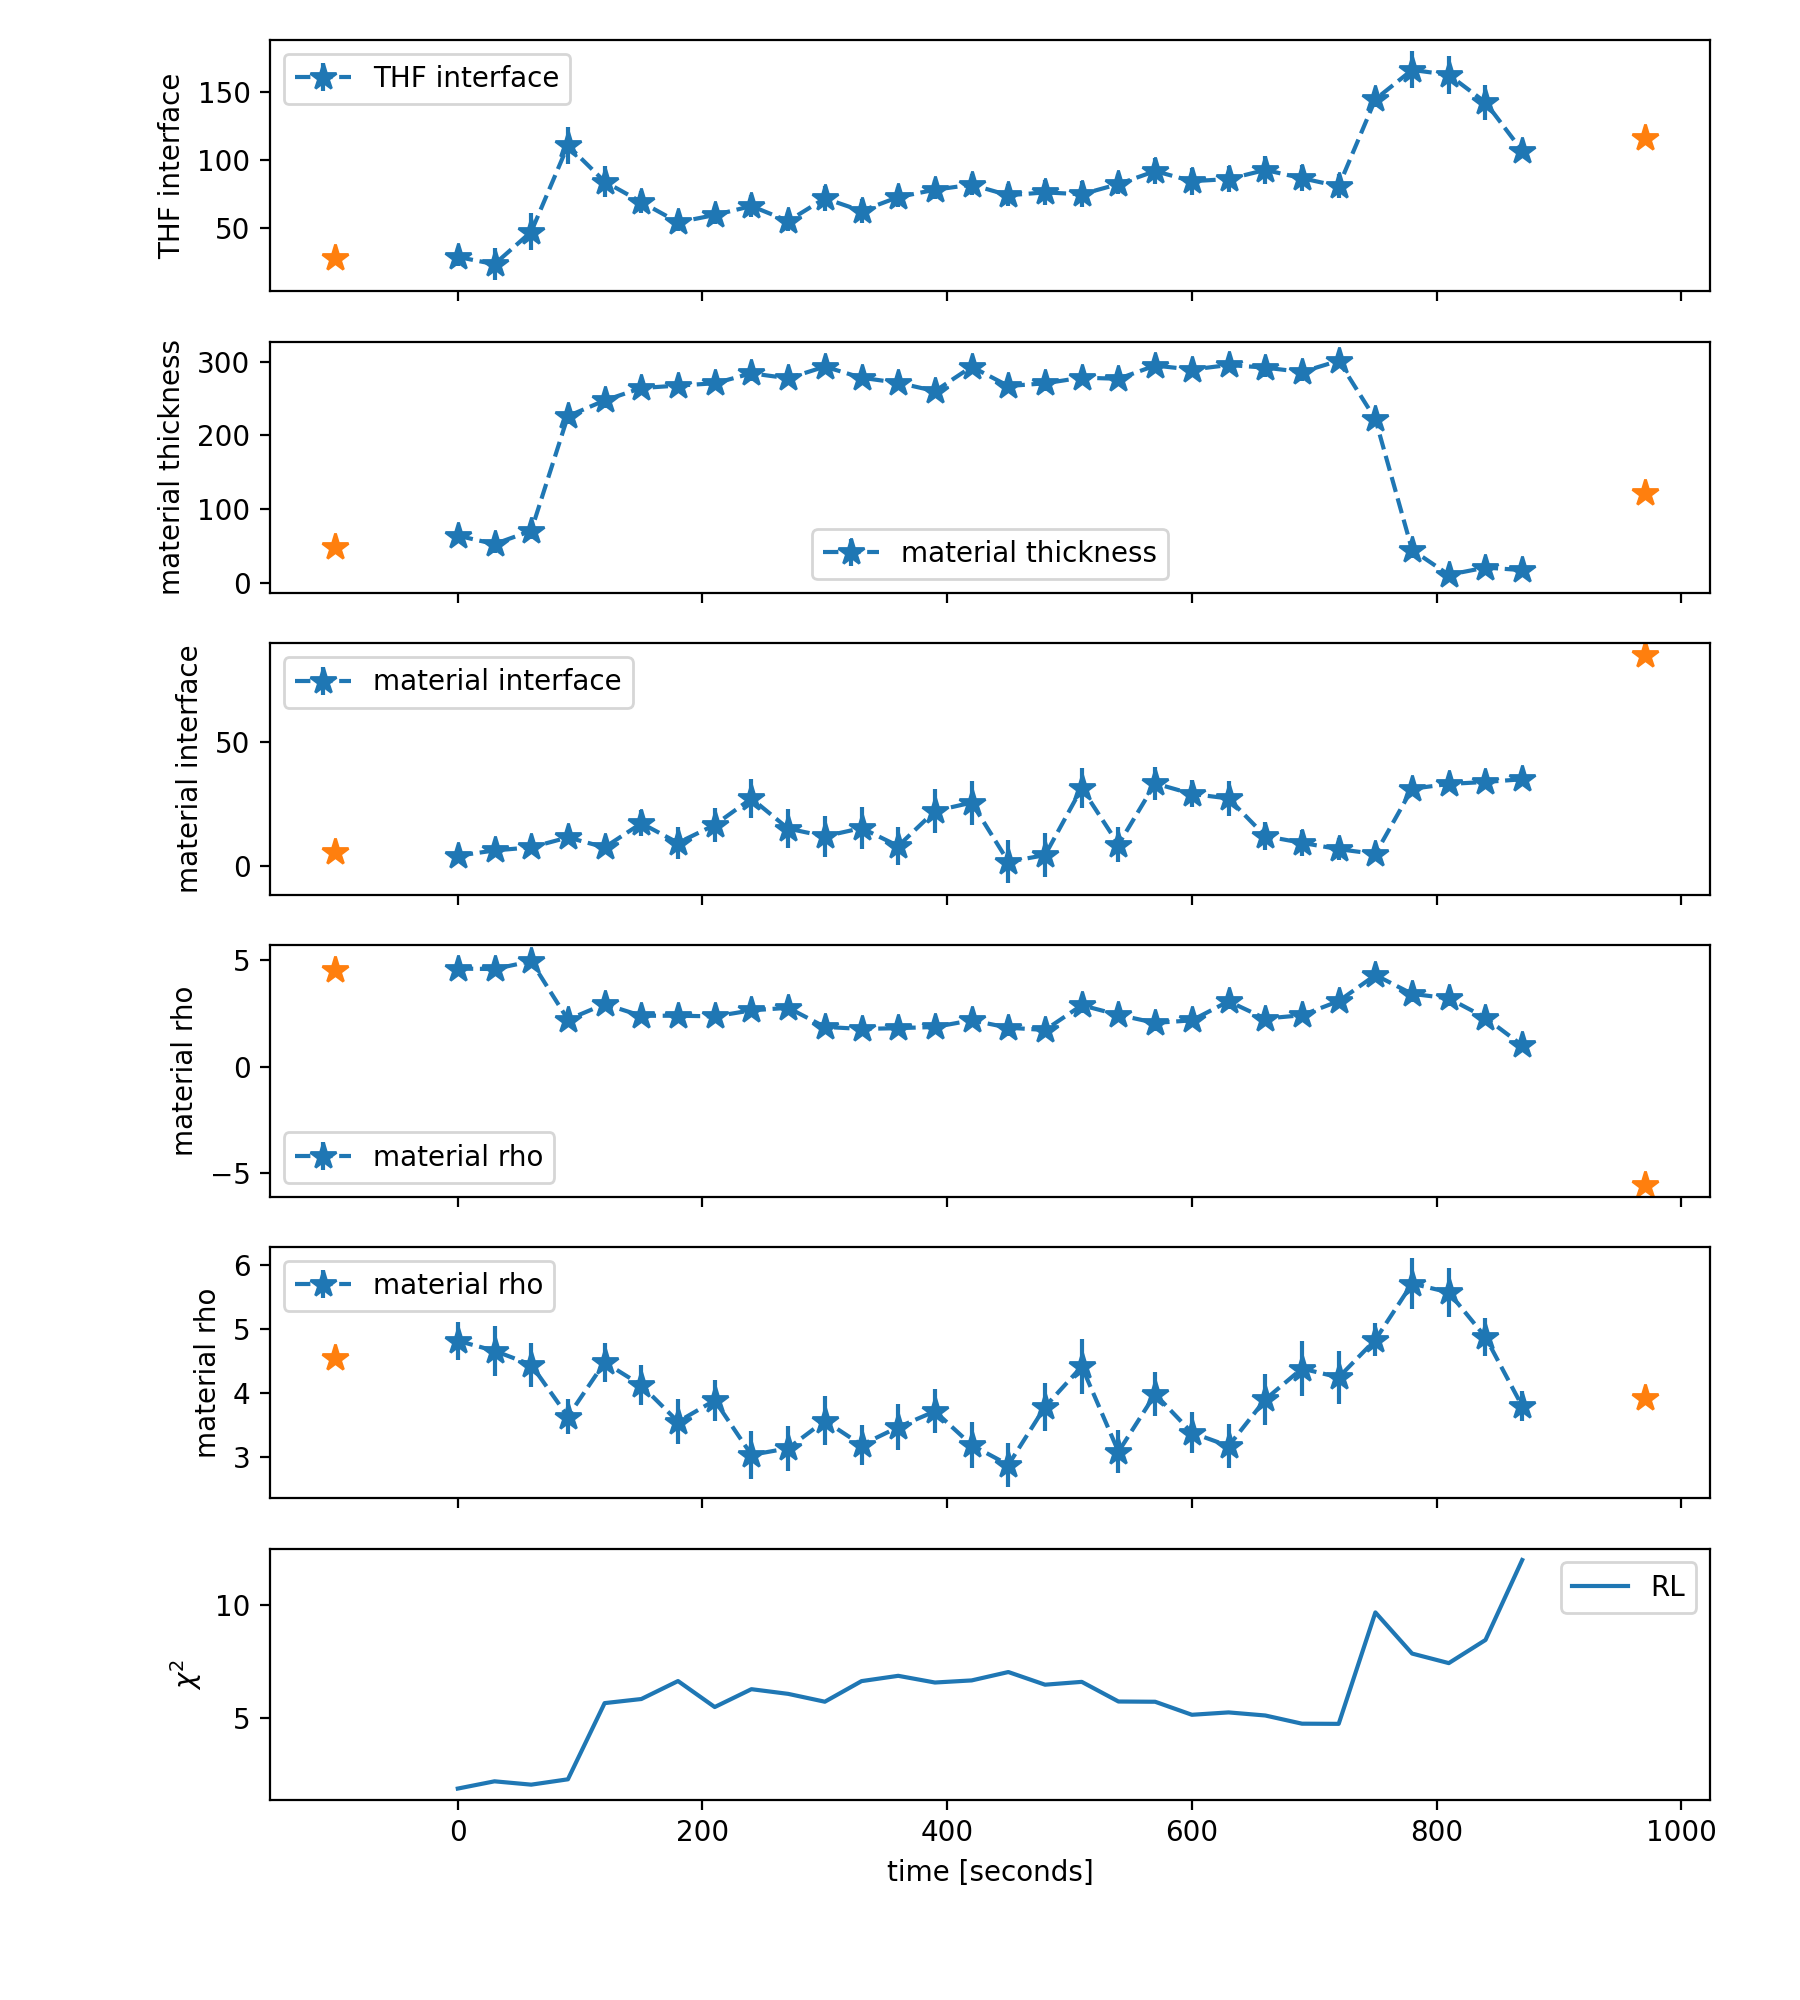

['THF interface', 'material thickness', 'material interface', 'material rho', 'material rho']


Text(0.5, 0, 'time [seconds]')

In [375]:
deltas = env.high_array - env.low_array
values = env.low_array + (1+actions[:,:len(env.parameters)]) * deltas / 2.0

pars = values.T


t_delay = 100
if REVERSE:
    t_initial = timestamps[-1]+t_delay
    t_final = -t_delay
    _times = np.flip(timestamps)
else:
    t_final = timestamps[-1]+t_delay
    t_initial = -t_delay
    _times = timestamps

n_times = len(env.data)

n_plots = pars.shape[0]+1

fig, axs = plt.subplots(n_plots, 1, dpi=100, figsize=(9,10), sharex=True)
plt.subplots_adjust(left=0.15, right=.95, top=0.98, bottom=0.1)
        
print(env.par_labels)
for i in range(pars.shape[0]):
    ax = plt.subplot(n_plots, 1, i+1)
    
    plt.errorbar(_times, pars[i], yerr=errs[i], label=env.par_labels[i], linestyle='--', marker='*', markersize=10)


    plt.plot([t_initial, t_final], [env.parameters[i], env.end_parameters[i]], linestyle='', marker='*', markersize=10)
    
    plt.ylabel(env.par_labels[i])
    plt.legend()

i +=1
ax = plt.subplot(n_plots, 1, i+1)
plt.plot(_times, chi2, label = 'RL')
plt.legend()
plt.ylabel("$\chi^2$")
plt.xlabel("time [seconds]")

Number of times: 30


<IPython.core.display.Javascript object>


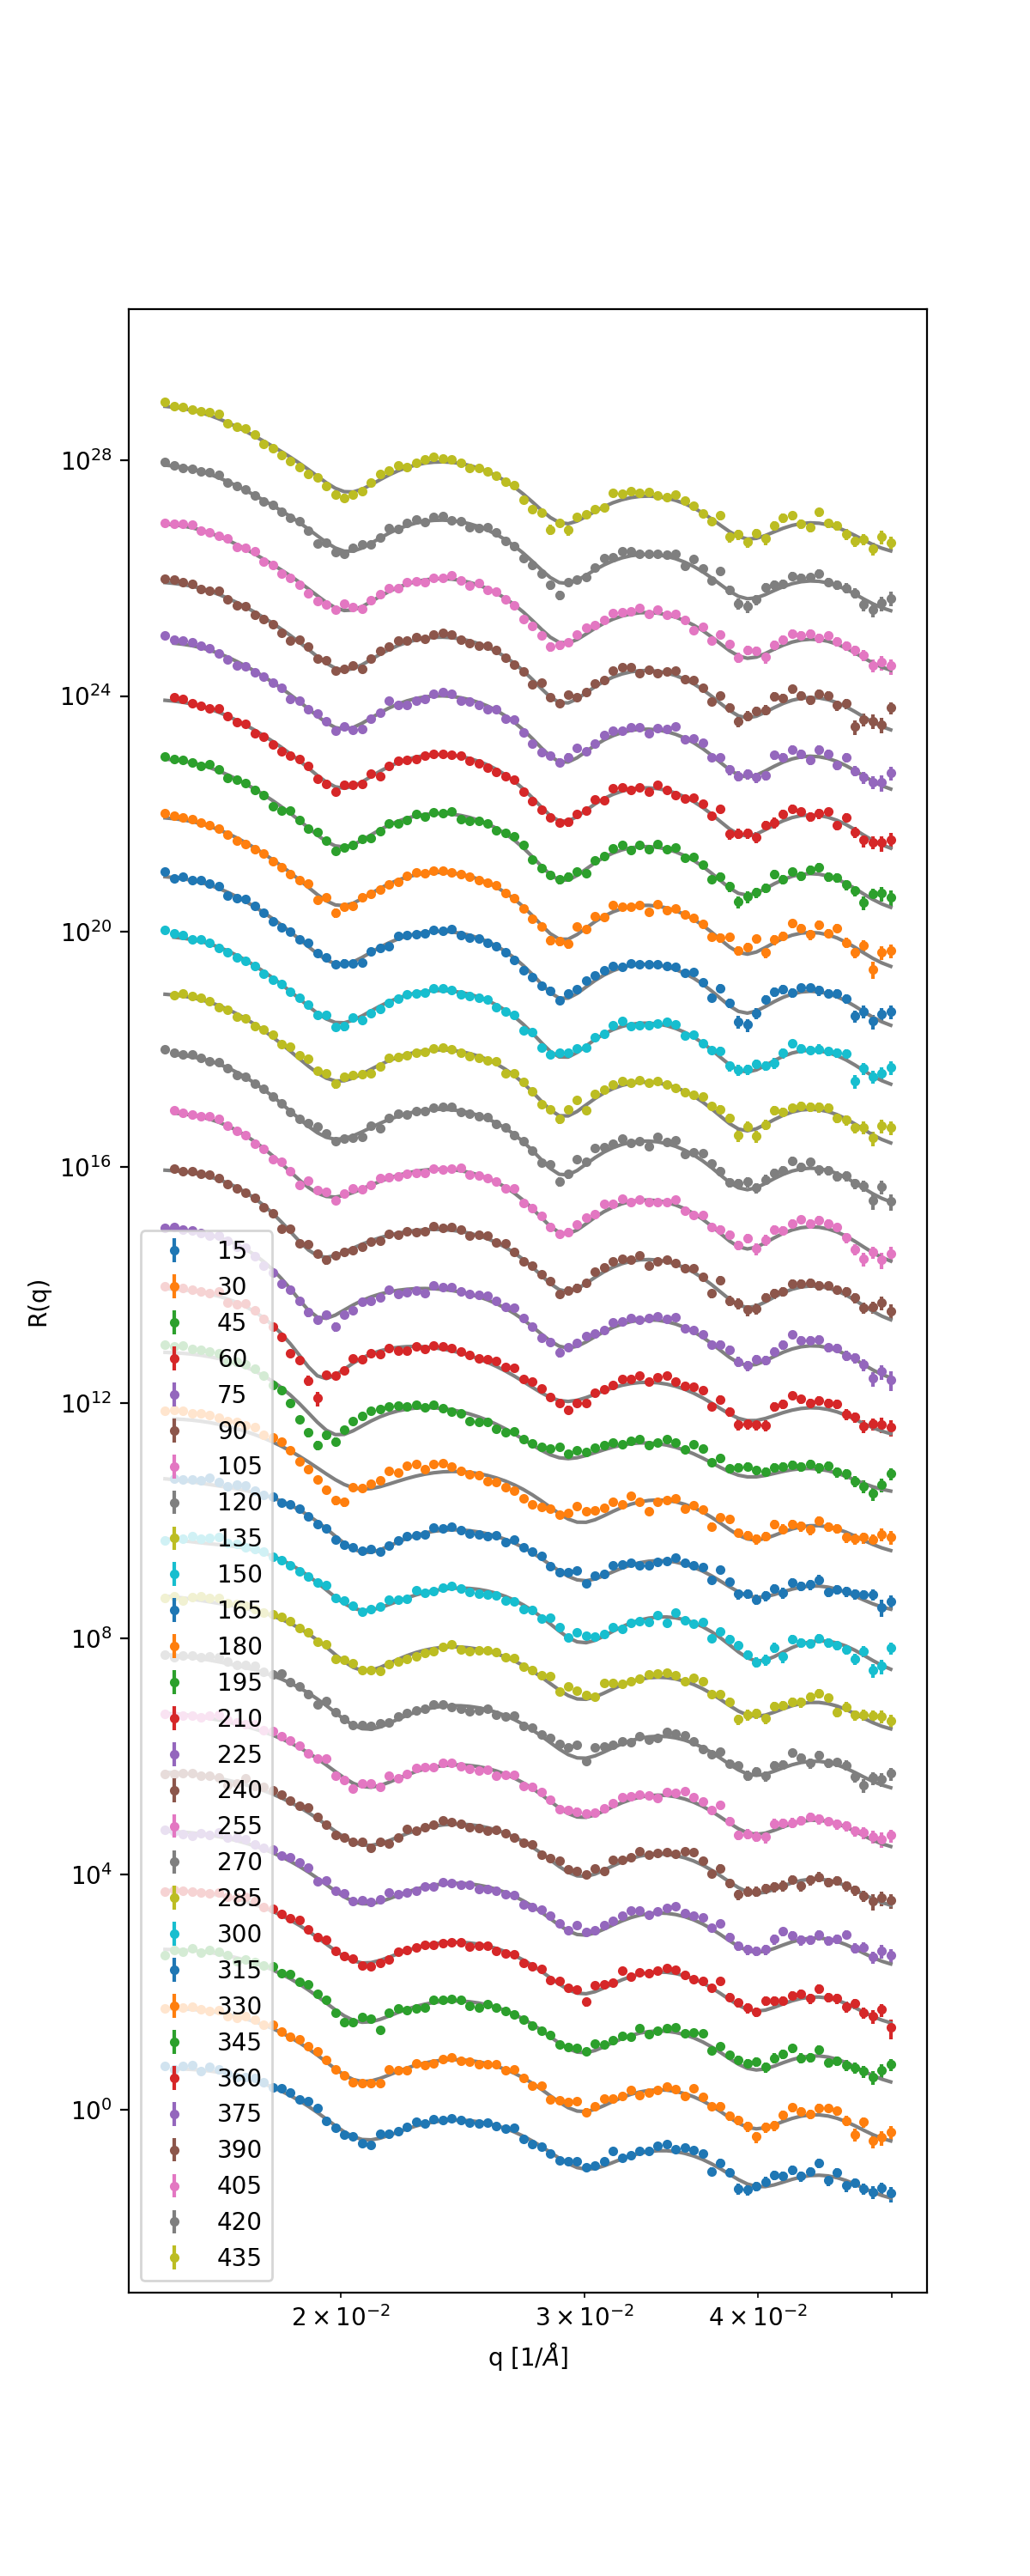

In [368]:
# Evaluate the agent
episode_reward = 0

n_times = len(env.data)
print("Number of times: %s" % n_times)

obs, info = env.reset()

fig = plt.subplots(dpi=100, figsize=(6, 15))

for i in range(1, n_times, 1):
    action, _ = model.predict(obs, deterministic=True)
    
    obs, reward, terminated, truncated, info = env.step(action)

    
    env.plot(scale=10.**i, newfig=False, errors=True, label=times[i])


Number of times: 30


<IPython.core.display.Javascript object>


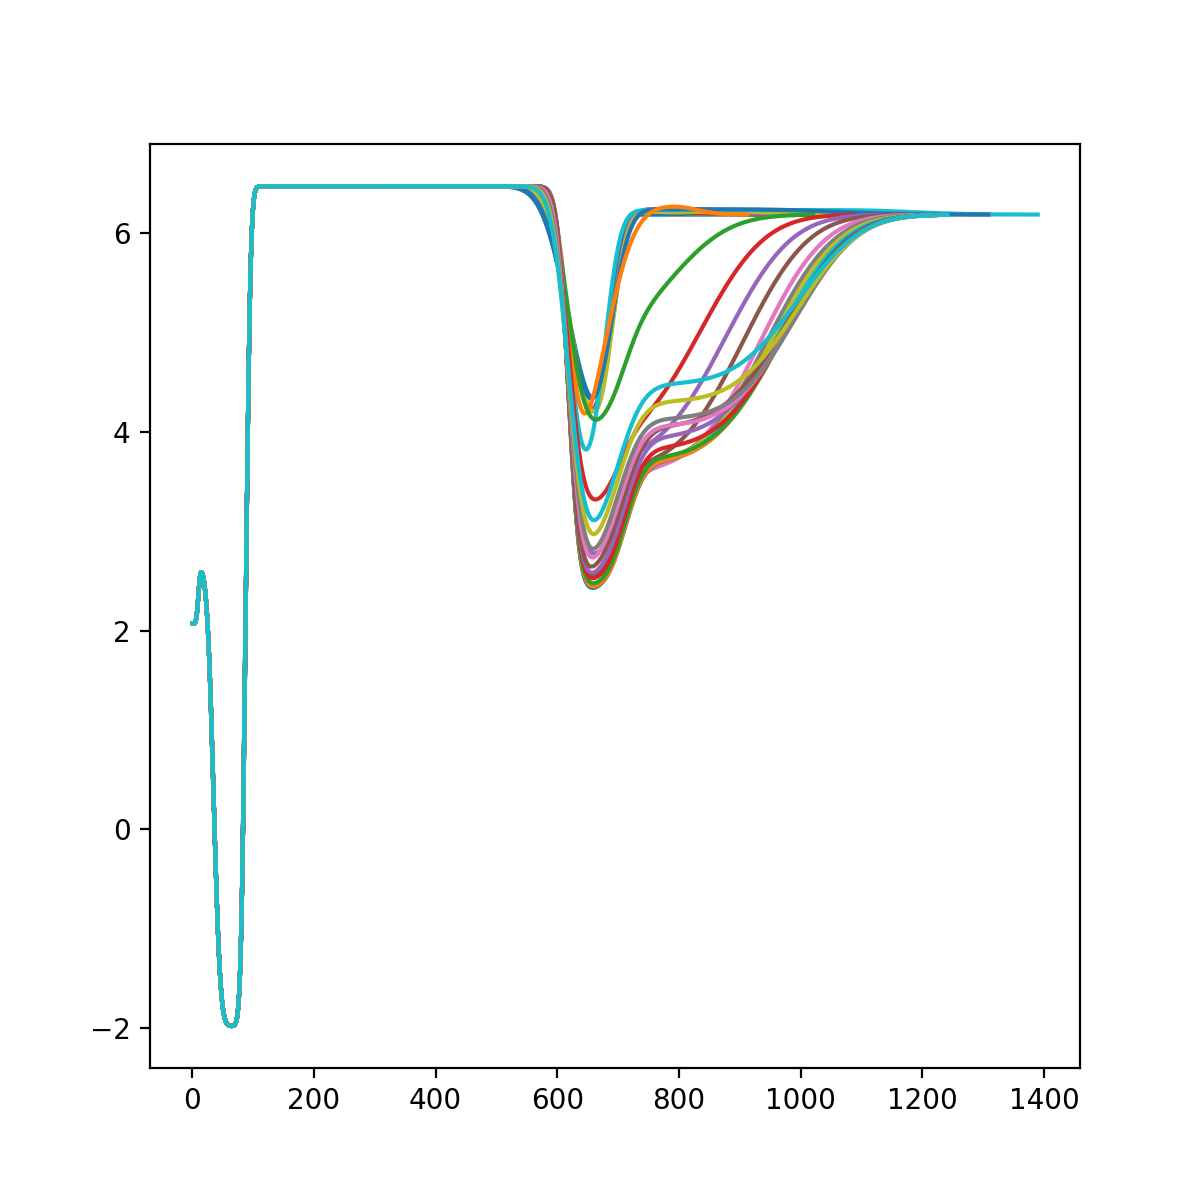

In [369]:
# Evaluate the agent
episode_reward = 0

n_times = len(env.data)
print("Number of times: %s" % n_times)

obs, info = env.reset()

fig = plt.subplots(dpi=100, figsize=(6, 6))

for i in range(0,30,1):
    action, _ = model.predict(obs, deterministic=True)
    
    obs, reward, terminated, truncated, info = env.step(action)
    z, sld, isld = env.ref_model.smooth_profile()
    
    plt.plot(-z+z[-1], sld)
